In [1]:
from pylab import *
import matplotlib.pylab as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib import rc



font = {'family' : 'serif',
        'serif': ['Computer Modern'],
        'weight' : 'bold',
        'size'   : 28}

rc('font', **font)
rc('text', usetex=True)

In [2]:
name_array = "18x18_pump_x/array_18x18.xyz"
epsi = 0.0
x,y,f,d = np.loadtxt(name_array,usecols=(1,2,4,5),skiprows=2,unpack=True)
ind = np.argsort(f)
natoms = int( len(x) )

In [3]:
#random matrix
def M_Rand(natoms=natoms):
    M_rand = rand(natoms,natoms)
    M_ones = ones((natoms,natoms))

    M_rand = (M_rand + M_rand.T)/2
    M_rand = 2*M_rand - M_ones

    M_mins = diag(ones(natoms))

    M_rand = M_rand - M_mins*M_rand
    return M_rand


In [4]:
M_rand = M_Rand()
def Hoti_Hamiltonian(γ, λ, ϵ=epsi,δ=0.0, natoms=natoms, M_rand=M_rand,x=x,y=y):
    r = 1.1
    Dic = {}
    natoms = int( len(x) )
    for n in range(natoms):
        a = sqrt( (x[n]-x)*(x[n]-x) + (y[n]-y)*(y[n]-y) ) < r 
        vecinos = [i for i, x in enumerate(a) if x and i!=n]
        Dic[n] = vecinos
        
    r = max(x) - 0.1
    Dic_further = {}
    Dic_furtherx = {}
    Dic_furthery = {}
    for n in range(natoms):
        a = sqrt( (x[n]-x)*(x[n]-x) + (y[n]-y)*(y[n]-y) ) > r
        vecinos  = [i for i, j in enumerate(a) if j and (x[n]==x[i] and y[n]==y[i])]
        vecinosx = [i for i, j in enumerate(a) if j and (x[n]==x[i])]
        vecinosy = [i for i, j in enumerate(a) if j and (y[n]==y[i])]
        Dic_further[n] = vecinos
        Dic_furtherx[n] = vecinosx
        Dic_furthery[n] = vecinosy
    
    
    H = np.zeros((natoms,natoms), dtype = 'complex')
    Hop = {}
    a = exp(-1J*pi)
    
    for n in Dic.keys():
        vecinos = Dic[n]
        hop = []
        for v in vecinos:
            f0 = f[n]
            f1 = f[v]
            
            if f0 == f1:
                fase = γ
            else: 
                fase = λ
            
            H[n,v] = fase 
            H[v,n] = fase 
            
            
            hop.append(fase)
        Hop[n] = hop

    f0 = 0
    f1 = 0
    fase = 1
    for n in Dic.keys():
        vecinos = Dic[n]
        for v in vecinos:
            posx     = x[n]
            posy     = y[n]
            f0       = f[n]
            f1       = f[v] 
            if f0 == f1:
                fase = γ
            else: 
                fase = λ
                
            if ( posy%2==0  ):
                  if ( x[v] > x[n] ):
                    H[n,v] = a*fase 
                    H[v,n] = a*fase 
           
            else:
                pass

                
    H_delta = δ*array(d)
    H_delta = diag(resize(H_delta,natoms), k=0)
    #print(H_delta)
    if ϵ > 0.0:
        H_rand = H * ϵ * M_rand 
        return H + H_rand + H_delta
    else:    
        return H + H_delta

In [55]:
H0 = Hoti_Hamiltonian(0.5,1,ϵ=0.0)
Ek0, U0 = eigh(H0)
Ek0 = np.real(Ek0)
indexsort = argsort(Ek0)
Est  = argsort(abs(Ek0))[0:4]
NEst  = argsort(abs(Ek0))[4:]

Ey = Ek0
count = 0
Ek_array = [Ey,Ey,Ey,Ey,Ey]

for ϵ in [0.01,0.05,0.1,0.3,0.5]:
    H = Hoti_Hamiltonian(0.5,1,ϵ=ϵ)
    Ek, U = eigh(H)
    Ek = np.real(Ek)

    Ey = abs(Ek0[indexsort] - Ek[indexsort])
    
    for i in range(49):
        M_rand1 = M_Rand(natoms=natoms)
        H1 = Hoti_Hamiltonian(0.5,1,ϵ=ϵ,M_rand=M_rand1)
        Ek1, U1 = eigh(H1)
        Ek1 = np.real(Ek1)

        Ey1 = abs(Ek0[indexsort] - Ek1[indexsort])
        Ey += Ey1
    
    Ek_array[count] = Ey/50
    count+=1
#len(Ey)/2


In [7]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

<ipython-input-57-84806e87134c>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


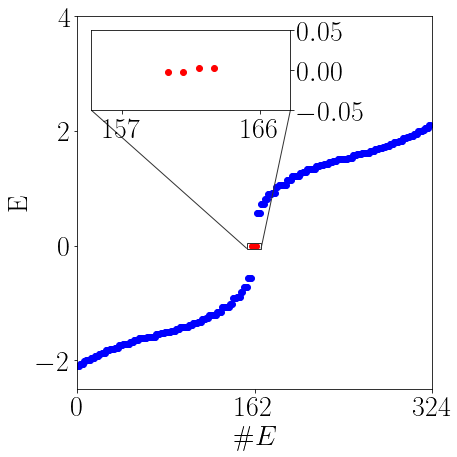

In [57]:
fig,ax = plt.subplots(figsize=(7,7)) 

axins = zoomed_inset_axes(ax, 14, loc='upper left')

ax.scatter(arange(len(Ey))[Est],Ek0[indexsort][Est], c='red') 
ax.scatter(arange(len(Ey))[NEst],Ek0[indexsort][NEst], c='blue') 
ax.set_ylabel('E')
ax.set_xlabel('$\#E$')
ax.set_ylim((-2.5,4))
ax.set_xlim((0,len(Ey)))

ax.set_xticks([0,162,len(Ey)])

axins.scatter(arange(len(Ey))[Est],Ek0[indexsort][Est], c='red') 
axins.set_xlim(155,168)
axins.set_xticks([157,166])
#axins.set_yticks([0.0])
axins.set_ylim(-0.05,0.05)
axins.yaxis.set_ticks_position("right")
#axins.set_ylabel('E')
#axins.set_xlabel('$\#E$')

mark_inset(ax, axins, loc1=3, loc2=4, fc="none",ec="0.2")
plt.tight_layout()

plt.savefig('spectre_square.pdf')
plt.savefig('spectre_square.png')

<ipython-input-58-7595d141833e>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[0.00060602 0.00153977 0.00060602 0.00153977]


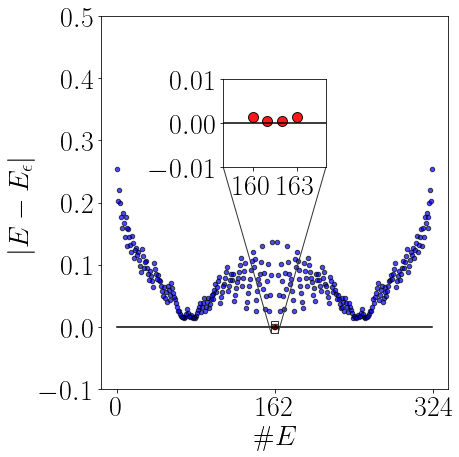

In [58]:
fig,ax = plt.subplots(figsize=(7,7)) 
i = 4
axins = zoomed_inset_axes(ax, 15, loc='upper center')
ax.plot(arange(len(Ey)),zeros(len(Ey)), c='black')
#for i in range(len(Ek_array))[-1]:

#ax[2].scatter(arange(len(Ey))[Est],Ek_array[i][Est], cmap='winter',
  #            s=i*50, alpha=1/(2*i+1), edgecolor='black')
#ax[2].scatter(arange(len(Ey))[NEst],Ek_array[i][NEst], c='blue',
 #             s=i*50, alpha=1/(2*i+1), edgecolor='black')
ax.scatter(arange(len(Ey))[Est],Ek_array[i][Est],s=20,alpha=0.7,
              c='red', edgecolor='black')
ax.scatter(arange(len(Ey))[NEst],Ek_array[i][NEst],s=20,alpha=0.7,c='blue'
              ,edgecolor='black')
#ax[2].plot(arange(len(Ey)),Ek_array[i], c='black')
#ax[3].plot(arange(len(Ey)),Ek_array[i], c='black')

#ax[3].scatter(arange(len(Ey))[Est],Ek_array[i][Est], c='red',
 #             s=i*50, alpha=1/(2*i+1), edgecolor='black') 
#ax[3].scatter(arange(len(Ey))[NEst],Ek_array[i][NEst], c='blue',
 #             s=i*50, alpha=1/(2*i+1), edgecolor='black')  

axins.plot(arange(len(Ey)),zeros(len(Ey)), c='black')
axins.scatter(arange(len(Ey))[Est],Ek_array[i][Est],s=100,alpha=0.9,
              c='red', edgecolor='black')
#axins.scatter(arange(len(Ey))[NEst],Ek_array[i][NEst],s=100,alpha=1/(i+1),c=Ek_array[i][NEst],
  #            cmap='winter', edgecolor='black')
axins.scatter(arange(len(Ey))[NEst],Ek_array[i][NEst],s=100,alpha=0.7,c='blue'
              , edgecolor='black')



#axins.set_xticks([156,162,167])
#axins.set_ylabel('$|E-E_\epsilon|$')
#axins.set_xlabel('$\#E$')
ax.set_ylim(-0.1,0.5)
ax.set_xticks([0,162,len(Ey)])
ax.set_ylabel('$|E-E_\epsilon|$')
ax.set_xlabel('$\#E$')

axins.set_xlim(158,165)
axins.set_ylim(-0.01,0.01)
axins.set_aspect(300)
axins.set_xticks([160,163])
mark_inset(ax, axins, loc1=3, loc2=4, fc="none",ec="0.2")

plt.draw()
plt.tight_layout()
#plt.show()
print(Ek_array[i][Est])
plt.savefig('spectre_square_epsi.pdf')
plt.savefig('spectre_square_epsi.png')


In [59]:
for i in range(len(Ek_array)):

    #ax[2].scatter(arange(len(Ey))[Est],Ek_array[i][Est], cmap='winter',
      #            s=i*50, alpha=1/(2*i+1), edgecolor='black')
    #ax[2].scatter(arange(len(Ey))[NEst],Ek_array[i][NEst], c='blue',
     #             s=i*50, alpha=1/(2*i+1), edgecolor='black')
    ax[2].scatter(arange(len(Ey)),Ek_array[i],s=i*50,alpha=1/(2*i+1),c=Ek_array[i],
                  cmap='winter', edgecolor='black')
    #ax[2].plot(arange(len(Ey)),Ek_array[i], c='black')
    #ax[3].plot(arange(len(Ey)),Ek_array[i], c='black')
    
    ax[2].set_ylabel('$|E-E_\epsilon|$')
    ax[2].set_xlabel('$\#E$')

    #ax[3].scatter(arange(len(Ey))[Est],Ek_array[i][Est], c='red',
     #             s=i*50, alpha=1/(2*i+1), edgecolor='black') 
    #ax[3].scatter(arange(len(Ey))[NEst],Ek_array[i][NEst], c='blue',
     #             s=i*50, alpha=1/(2*i+1), edgecolor='black')  
    ax[3].scatter(arange(len(Ey)),Ek_array[i],s=i*50,alpha=1/(2*i+1),c=Ek_array[i],
                  cmap='winter', edgecolor='black')
    
    ax[3].set_xlim(155,168)
    ax[3].set_ylim(-0.1,0.2)
    ax[3].set_xticks([156,162,167])
    ax[3].set_ylabel('$|E-E_\epsilon|$')
    ax[3].set_xlabel('$\#E$')


TypeError: 'AxesSubplot' object is not subscriptable

In [5]:
name_array = "../Hoti_variaciones_Fractal/18x18_pump_x/LatticeSierpinski_18x18.xyz"
x,y,f,d = np.loadtxt(name_array,usecols=(1,2,4,5),skiprows=2,unpack=True)
natoms = int( len(x) )
M_rand = M_Rand(natoms=natoms)
H0 = Hoti_Hamiltonian(0.3,1,ϵ=0.0,x=x,y=y,M_rand=M_rand)
Ek0, U0 = eigh(H0)
Ek0 = np.real(Ek0)
indexsort = argsort(Ek0)
Est  = argsort(abs(Ek0))[0:4]
NEst  = argsort(abs(Ek0))[4:]

Ey = Ek0
count = 0
Ek_array = [Ey,Ey,Ey,Ey,Ey]

for ϵ in [0.01,0.05,0.1,0.3,0.5]:
    H = Hoti_Hamiltonian(0.3,1,ϵ=ϵ,x=x,y=y,M_rand=M_rand)
    Ek, U = eigh(H)
    Ek = np.real(Ek)

    Ey = abs(Ek0[indexsort] - Ek[indexsort])
    
    for i in range(49):
        M_rand1 = M_Rand(natoms=natoms)
        H1 = Hoti_Hamiltonian(0.3,1,ϵ=ϵ,x=x,y=y,M_rand=M_rand1)
        Ek1, U1 = eigh(H1)
        Ek1 = np.real(Ek1)

        Ey1 = abs(Ek0[indexsort] - Ek1[indexsort])
        Ey += Ey1
    
    Ek_array[count] = Ey/50
    count+=1

<ipython-input-8-670f677ff6ed>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


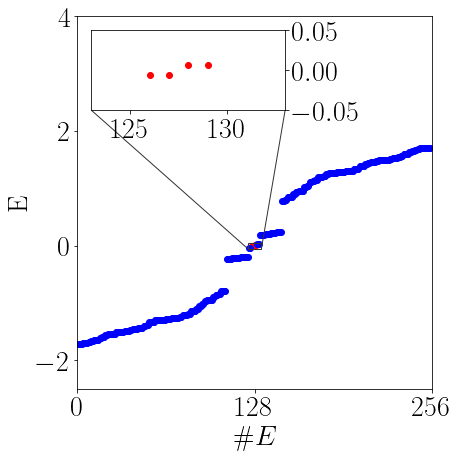

In [8]:
fig,ax = plt.subplots(figsize=(7,7)) 

axins = zoomed_inset_axes(ax, 14, loc='upper left')

ax.scatter(arange(len(Ey))[Est],Ek0[indexsort][Est], c='red') 
ax.scatter(arange(len(Ey))[NEst],Ek0[indexsort][NEst], c='blue') 
ax.set_ylabel('E')
ax.set_xlabel('$\#E$')
ax.set_ylim((-2.5,4))
ax.set_xlim((0,len(Ey)))

ax.set_xticks([0,128,len(Ey)])

axins.scatter(arange(len(Ey))[Est],Ek0[indexsort][Est], c='red') 
axins.set_xlim(123,133)
axins.set_xticks([125,130])
#axins.set_yticks([0.0])
axins.set_ylim(-0.05,0.05)
axins.yaxis.set_ticks_position("right")
#axins.set_ylabel('E')
#axins.set_xlabel('$\#E$')

mark_inset(ax, axins, loc1=3, loc2=4, fc="none",ec="0.2")
plt.tight_layout()

plt.savefig('spectre_square_fractal.pdf')
plt.savefig('spectre_square_fractal.png')

[0.00113474 0.00113474 0.00129881 0.00129881]


<ipython-input-9-7ed81f9572d6>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


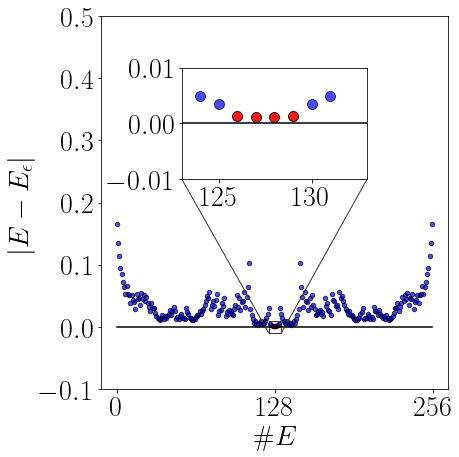

In [9]:
fig,ax = plt.subplots(figsize=(7,7)) 
i = 3
axins = zoomed_inset_axes(ax, 15, loc='upper center')
ax.plot(arange(len(Ey)),zeros(len(Ey)), c='black')
#for i in range(len(Ek_array))[-1]:

#ax[2].scatter(arange(len(Ey))[Est],Ek_array[i][Est], cmap='winter',
  #            s=i*50, alpha=1/(2*i+1), edgecolor='black')
#ax[2].scatter(arange(len(Ey))[NEst],Ek_array[i][NEst], c='blue',
 #             s=i*50, alpha=1/(2*i+1), edgecolor='black')
ax.scatter(arange(len(Ey))[Est],Ek_array[i][Est],s=20,alpha=0.7,
              c='red', edgecolor='black')
ax.scatter(arange(len(Ey))[NEst],Ek_array[i][NEst],s=20,alpha=0.7,c='blue'
              ,edgecolor='black')
#ax[2].plot(arange(len(Ey)),Ek_array[i], c='black')
#ax[3].plot(arange(len(Ey)),Ek_array[i], c='black')

#ax[3].scatter(arange(len(Ey))[Est],Ek_array[i][Est], c='red',
 #             s=i*50, alpha=1/(2*i+1), edgecolor='black') 
#ax[3].scatter(arange(len(Ey))[NEst],Ek_array[i][NEst], c='blue',
 #             s=i*50, alpha=1/(2*i+1), edgecolor='black')  

axins.plot(arange(len(Ey)),zeros(len(Ey)), c='black')
axins.scatter(arange(len(Ey))[Est],Ek_array[i][Est],s=100,alpha=0.9,
              c='red', edgecolor='black')
#axins.scatter(arange(len(Ey))[NEst],Ek_array[i][NEst],s=100,alpha=1/(i+1),c=Ek_array[i][NEst],
  #            cmap='winter', edgecolor='black')
axins.scatter(arange(len(Ey))[NEst],Ek_array[i][NEst],s=100,alpha=0.7,c='blue'
              , edgecolor='black')



#axins.set_xticks([156,162,167])
#axins.set_ylabel('$|E-E_\epsilon|$')
#axins.set_xlabel('$\#E$')
ax.set_ylim(-0.1,0.5)
ax.set_xticks([0,128,len(Ey)])
ax.set_ylabel('$|E-E_\epsilon|$')
ax.set_xlabel('$\#E$')

axins.set_xlim(123,133)
axins.set_ylim(-0.01,0.01)
axins.set_aspect(300)
axins.set_xticks([125,130])
mark_inset(ax, axins, loc1=3, loc2=4, fc="none",ec="0.2")

plt.draw()
plt.tight_layout()
#plt.show()
print(Ek_array[i][Est])
plt.savefig('spectre_square_epsi_fractal.pdf')
plt.savefig('spectre_square_epsi_fractal.png')


In [ ]:
name_array = "../Hoti_variaciones_Fractal/18x18_pump_x/LatticeSierpinski_54x54.xyz"
x,y,f,d = np.loadtxt(name_array,usecols=(1,2,4,5),skiprows=2,unpack=True)
natoms = int( len(x) )
M_rand = M_Rand(natoms=natoms)
H0 = Hoti_Hamiltonian(0.3,1,ϵ=0.0,x=x,y=y,M_rand=M_rand)
Ek0, U0 = eigh(H0)
Ek0 = np.real(Ek0)
indexsort = argsort(Ek0)


H = Hoti_Hamiltonian(0.5,1,ϵ=0.5,x=x,y=y,M_rand=M_rand)
Ek, U = eigh(H)
Ek = np.real(Ek)

Ey = abs(Ek0[indexsort] - Ek[indexsort])


for i in range(21):
    M_rand1 = M_Rand(natoms=natoms)
    H1 = Hoti_Hamiltonian(0.3,1,ϵ=0.5,M_rand=M_rand1,x=x,y=y)
    Ek1, U1 = eigh(H1)
    Ek1 = np.real(Ek1)

    Ey1 = abs(Ek0[indexsort] - Ek1[indexsort])
    Ey += Ey1

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6)) 

ax[0].scatter(range(len(Ey)),Ey/50)

ax[0].set_xlim(1014,1034)
ax[0].set_ylim(0.0,0.02)


ax[1].scatter(range(len(Ey)),Ey/50)

ax[2].scatter(range(len(Ey)),Ek0[indexsort]) 
ax[2].set_xlim(1014,1034)
ax[2].set_ylim(-0.02,0.02)

len(Ey)/2